# Assignment 6
Max Norton  
November 3, 2018

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.3.1") # activate the QuantEcon environment

using LinearAlgebra, Statistics, Compat # load common packages

### Exercise 1

Explore the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl)

**Describe 2 abstract types and the hierarchy of 3 different concrete types**

The general idea of StaticArray.jl is to introduce a set of types of arrays (including both vectors and matrices) that are parameterized by their size, aka their dimensions. That is, rather than size being a property of the array itself, size is stored as a property of the type. This apparently has performance-enhancing effects have arrays up to a certain size (estimated to be around 100 elements). I guess an example of how this performance enhancement might occur is that the compiler could check that two arrays are dimensionally matched such that the operation is defined.

The most important abstract type introduced is `StaticArray{Size,T,N}` which has parent type `AbstractArray{T,N}`. So StaticArray is just an AbstractArray with elements of type T and number of dimensions N, where the actual dimensions `Size` are made a type parameter in the form of a tuple. So if a StaticArray was 2x2, it would have size (2,2) and N of 2. Analogously to the same way that a Matrix is a DenseArray where the type itself conveys the information that N=2, a StaticArray is an AbstractArray where the type itself carries information about size.

Most of the concrete types introduced in StaticArrays are descendants of `StaticArray`. In addition to size, concrete types of StaticArrays also include length (number of elements) as a parameter of the type. For instance,

1. `SArray{Size,T,N,L}` is an immutable, concrete type of StaticArray with four parameters: 

 - Size, a tuple given the dimensions of its contents
 - T, a type (or, probably suboptimally, I'd guess it can be an array of types)
 - N, the number of dimensions (i.e. the number of entries in Size. This parameter isn't mentioned in the StaticArrays.jl documentation, but it's clearly there in the type
 - L, the length, i.e. the product of the elements of Size

Hierarchy: `SArray{Size,T,N,L} <: StaticArray{Size,T,N} <: AbstractArray{T,N} <: Any`

2. `MArray{Size,T,N,L}` is a mutable concrete type that is otherwise exactly like `SArray`.

Hierarchy: `MArray{Size,T,N,L} <: StaticArray{Size,T,N} <: AbstractArray{T,N} <: Any`

3. `SVector{Size, T}` is a static array in one dimension. It requires fewer parameters because for any SVector, size = 1 x length.

Hierarchy: `SVector{Size,T} <: StaticArray{Size,T,1} <: AbstractArray{T,1} <: Any`

Other concrete types work in similar ways. For example, there is a `SMatrix{Size1, Size2, T, L}` which is inherently 2-dimensional (so it has no N) but since the sizes of each of its dimensions depends on the instance, it has two size parameters and a length parameter. There are also equivalent `MVector` and `MMatrix` types. Further, there's another concrete type, `SizedArray`. I don't completely follow the difference between this and SArray.

Another (the other, I think) abstract type introduced in the package is `FieldVector(N, T)`. This is included to enable the creation of bespoke concrete vector types beneath it that inherit the performance benefit of including the size (i.e. length) as a type parameter. These concrete types can be mutable or immutable. For example, you might use an immutable concrete type that inherits `FieldVector` in the same way you'd use a named tuple, but with a performance boost for some types of dimension-dependent operations.

**Benchmark the calculation of some simple linear algebra with a static array compared to the following for a dense arrays for N=3 and N=15**

In [2]:
using BenchmarkTools, StaticArrays
N = [3, 15]
a, A = rand.(N, N)
x, X = rand.(N)
@btime $a * $x
@btime inv($a)

@btime $A * $X
@btime inv($A);

  89.738 ns (1 allocation: 112 bytes)
  654.386 ns (5 allocations: 1.98 KiB)
  147.362 ns (1 allocation: 208 bytes)
  24.900 μs (5 allocations: 9.88 KiB)


In [3]:
sta=SMatrix{N[1],N[1]}(a)
stA=SMatrix{N[2],N[2]}(A) # would be cool to combine these lines
stx=SVector{N[1]}(x)
stX=SVector{N[2]}(X)
@btime $sta * $stx
@btime inv($sta)

@btime $stA * stX
@btime inv($stA);

  4.204 ns (0 allocations: 0 bytes)
  21.875 ns (0 allocations: 0 bytes)
  479.592 ns (2 allocations: 1.89 KiB)
  28.800 μs (6 allocations: 11.86 KiB)


Observation: Much faster with static arrays in the 3x3 case (L=9<100); static arrays slower in the 15x15 multiplication operation (L=225>100); the 15x15 inverse results are not noticeably sensitive to the type choice.

### Exercise 2

**Benchmark the Kalman gain using Static Arrays.**

In [149]:
Σ = [0.4  0.3;
    0.3 0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R);

  765.103 ns (10 allocations: 1.94 KiB)


In [152]:
Σst=SMatrix{2,2}(Σ); Gst = SMatrix{2,2}(G); Rst = SMatrix{2,2}(R);

@btime gain($Σst, $Gst, $Rst);

  21.486 ns (0 allocations: 0 bytes)


Using Static arrays gives us a 765.103/21.486 = 35.6x speedup.

### Exercise 3

In [4]:
using Polynomials
p = Poly([2, -5, 2], :x) # :x just gives a symbol for display
@show p
p′ = polyder(p) # gives the derivative of p, another polynomial
@show p(0.1), p′(0.1) # call like a function
@show roots(p); # find roots such that p(x) = 0

p = Poly(2 - 5*x + 2*x^2)
(p(0.1), p′(0.1)) = (1.52, -4.6)
roots(p) = [2.0, 0.5]


**Plot both `p(x)` and `p′(x)` for $ x \in [-2, 2] $**

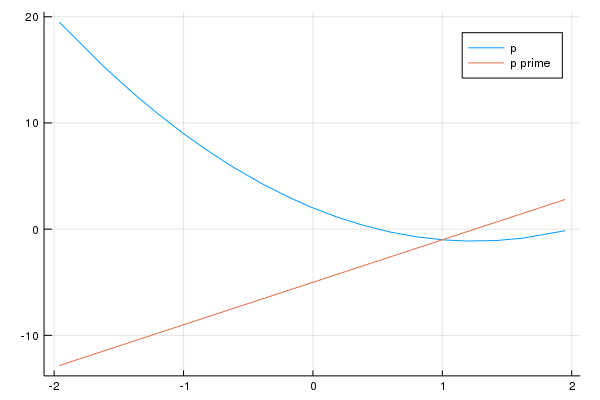

In [5]:
using Plots
gr(fmt=:png)

plot(x -> p(x), -2, 2, label="p")
plot!(x -> p′(x), -2, 2, label="p prime")

In [6]:
#root of p′ looks weird
@show roots(p′)

roots(p′) = [1.25]


1-element Array{Float64,1}:
 1.25

$-5 + 4 \times 1.25 = -5 + 5 = 0$

ok, it's correct

### Exercise 4

Using your solution to Exercise 8(a/b) in the [Julia By Example Lecture](julia_by_example) to create a specialized version of Newton’s method for Polynomials, using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`, where the `p::Poly` ensure that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built in `roots(p)`

In [17]:
using ForwardDiff

# from the old assignment
function newtonsmethod(f, x_0; tolerance = 1E-7, maxiter = 1000)
    @assert false # Only calling newtonsmethod on p, so if I actually enter this old version, there's something wrong
    Diff(f) = x -> ForwardDiff.derivative(f, x)
    f_prime = Diff(f)
    x_old = x_0
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = x_old - f(x_old)/f_prime(x_old) #implement the Newtom alg
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter += 1
    end
    return (x_old, normdiff, iter)
end


# new method
function newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter=100)
    p_prime = polyder(p)
    x_old = x_0
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = x_old - f(x_old)/p_prime(x_old) #implement the Newtom alg
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter += 1
    end
    return (x_old, normdiff, iter)
end


@btime newtonsmethod(p, 0)
@btime roots(p);

  1.540 μs (9 allocations: 4.59 KiB)
  3.556 μs (24 allocations: 2.34 KiB)


My function works better than roots()? Seems nonsensical. On the other hand roots() find both and my function only first the first one it stumbles across, so this is an unfair comparison.

### Exercise 5 (Advanced)

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximate an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple-dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * exploit the fact that `AbstractRange` have constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * for this, build a uniform grid with `N` points on `[x̲,x̄]`, call the `f` function at those grid points, and use the existing `trapezoidal(f, x)` from the implementation  

In [8]:
function trapezoidal(f::AbstractArray, x::AbstractArray)
    @assert length(x)==length(f)
    est = 0.0
    for n in 2:length(x)
        est += ( ( f[n-1]+f[n] ) / 2 ) * (x[n] - x[n-1])
    end
    est
end

trapezoidal (generic function with 1 method)

In [9]:
function trapezoidal(f::AbstractArray, x::AbstractRange)
    @assert length(x)==length(f)
    est = 0.0
    for n in 2:length(x)
        est += ( ( f[n-1]+f[n] ) / 2 ) * step(x)
    end
    est
end

trapezoidal (generic function with 2 methods)

In [10]:
function trapezoidal(f::Function, x̲::Real, x̄::Real, N::Real)
    grid = range(x̲, stop=x̄, length=N)
    f_array = f.(grid)
    trapezoidal(f_array, grid)
end

trapezoidal (generic function with 3 methods)

**1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $**

In [11]:
f(x) = x^2
x̲ = 0.0; x̄=1.0;
x_range = range(x̲, x̄, step=0.01)
x_array = collect(x_range)
f_array = f.(x_array)

@show trapezoidal(f_array, x_array)
@show trapezoidal(f_array, x_range)
@show trapezoidal(f, x̲, x̄, 101);

trapezoidal(f_array, x_array) = 0.33335000000000004
trapezoidal(f_array, x_range) = 0.3333499999999999
trapezoidal(f, x̲, x̄, 101) = 0.3333499999999999


**2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values**

$$\int_0^1 x^2 dx = \frac{x^3}{3}\big{|}_0^1 = \frac{1}{3}$$

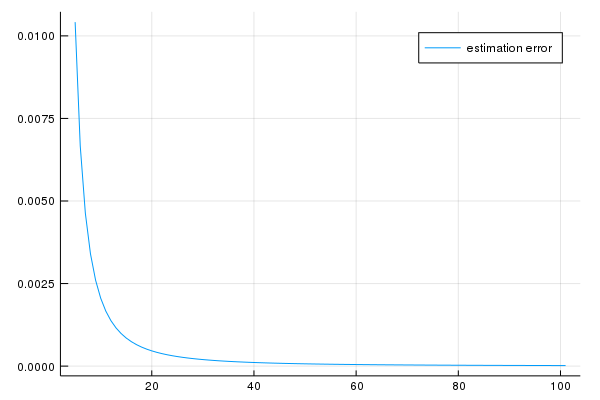

In [12]:
n_grid = collect(5:1:101)

plot(n_grid, trapezoidal.(f, x̲, x̄, n_grid) .- 1//3, label = "estimation error")

**3. Consider trying different functions for $ f(x) $ and comparing the solutions for various `N`.** When trying different functions, instead of integrating by hand consider using a high-accuracy library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

In [13]:
using QuadGK
f(x) = x^2
g(x) = p(x)
h(x) = exp(x)
my_fctns(x) = [f, g, h]

quadgk.(my_fctns(x), 0.0, 1.0)

3-element Array{Tuple{Float64,Float64},1}:
 (0.3333333333333333, 5.551115123125783e-17)
 (0.1666666666666667, 0.0)                  
 (1.718281828459045, 0.0)                   

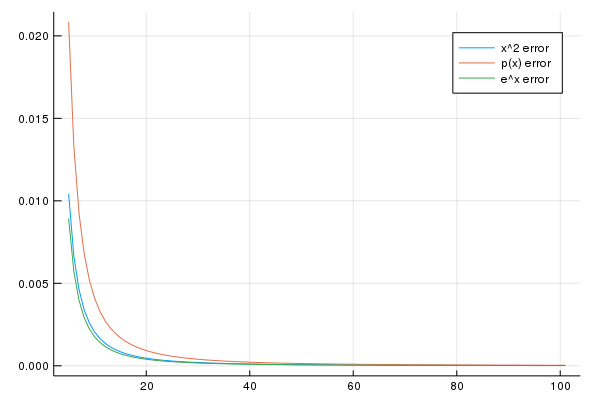

In [14]:
plot(n_grid, trapezoidal.(f, x̲, x̄, n_grid) .- quadgk(f, x̲, x̄)[1], label = "x^2 error")
plot!(n_grid, trapezoidal.(g, x̲, x̄, n_grid) .- quadgk(p, x̲, x̄)[1], label = "p(x) error")
plot!(n_grid, trapezoidal.(h, x̲, x̄, n_grid) .- quadgk(exp, x̲, x̄)[1], label = "e^x error")

### Exercise 6 (Advanced)

Take a variation of your code in Exercise 5 which implements the trapezoidal rule for the uniform grid

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$

In [15]:
function f2(a, b; N = 50)
    r = range(a, b, length=N) # one
return mean(r)
end
Df(x) = ForwardDiff.derivative(y -> f2(0.0, y), x)

Df (generic function with 1 method)

In [18]:
Df(4)

0.5

Comment: It doesn't really make sense to name my new method Df too, because it calculates something different, but I'm going to do it anyway to force myself to write in a manner that makes multiple dispatch work and adheres to decent generic programming style. But changed name of example f to f2 so it wouldn't overwrite my old f from problem 5, which I use to test the new Df method.

In [31]:
function Df(x̄, f::Function; x̲=0.0, N=50)
    x̲ != 0.0 ? a = x̲ : a = zero(x̄) 
    ForwardDiff.derivative(b -> trapezoidal(f, a, b, N), x̄)
end

Df (generic function with 2 methods)

Noticing that the test functions from problem 5 are all continuous, by the fundamental theorem of calculus part one, we should consistently find that $\frac{d}{d\bar{x}}\int_{\underline{x}}^{\bar{x}}f(x)dx = f(\bar{x}) \forall \underline{x}, \bar{x}$.

Recall that $f(x) = x^2; g(x) = 2-5x+2x^2; h(x) = e^x$.

In [34]:
@show Df(5.0, f)
@show f(5.0)
@show Df(3.0, g, N=100)
@show g(3.0)
@show Df(10.0, h, x̲=3)
@show h(10.0);

Df(5.0, f) = 25.00520616409829
f(5.0) = 25.0
Df(3.0, g, N=100) = 5.0009182736455475
g(3.0) = 5.0
Df(10.0, h, x̲=3) = 22074.598856939272
h(10.0) = 22026.465794806718


The approximations aren't perfect enough for \approx, but this looks pretty good.